In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install shap

     |████████████████████████████████| 327kB 3.4MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456460 sha256=89ca399d3cee228ba9f501461913f730ae24327c3302e9b6e5704e4160f191cb
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [3]:
# !ls -l
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.cm import get_cmap
import io
import math
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, QuantileTransformer
from sklearn.metrics import accuracy_score, average_precision_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

from xgboost import XGBClassifier
from xgboost import plot_tree
import shap

import seaborn as sns
import pickle

In [4]:
dataDir = '/content/gdrive/My Drive/00Projects/DNA Repair/prettyFigures/bothData/data'
figDir = '/content/gdrive/My Drive/00Projects/DNA Repair/prettyFigures/bothData/figures'
homeDir = '/content/gdrive/My Drive/00Projects/DNA Repair/prettyFigures/bothData/'
os.chdir(dataDir)

In [5]:
!ls -ltr

total 1079404
-rw------- 1 root root   2275820 Mar 20  2020 CPD_5kBTSS_DA_normalized.csv
-rw------- 1 root root   2276706 Mar 20  2020 CPD_5kBTSS_DB_normalized.csv
-rw------- 1 root root   2275209 Mar 20  2020 CPD_5kATSS_DA_normalized.csv
-rw------- 1 root root   2274918 Mar 20  2020 CPD_5kATSS_DB_normalized.csv
-rw------- 1 root root   2278989 Mar 20  2020 CPD_5kBTES_DA_normalized.csv
-rw------- 1 root root   2278972 Mar 20  2020 CPD_5kBTES_DB_normalized.csv
-rw------- 1 root root   2244992 Mar 20  2020 CPD_intergenic_DA_normalized.csv
-rw------- 1 root root   2246186 Mar 20  2020 CPD_intergenic_DB_normalized.csv
-rw------- 1 root root   2190245 Mar 20  2020 Cisplatin_5kBTSS_DA_normalized.csv
-rw------- 1 root root   2194078 Mar 20  2020 Cisplatin_5kBTSS_DB_normalized.csv
-rw------- 1 root root   2190310 Mar 20  2020 Cisplatin_5kBTES_DA_normalized.csv
-rw------- 1 root root   2193357 Mar 20  2020 Cisplatin_5kBTES_DB_normalized.csv
-rw------- 1 root root   2191654 Mar 20  2020 Cisplati

#Functions

## getRepairDF

In [6]:
def getRepairRegionDF(repairType, region, damageSample):
  '''
  repairType: one of ['64pp', 'CPD' or 'Cisplatin']
  region: one of ['all', '5kBTSS', '5kATSS', '5kBTES', 'intergenic']
  damageSample: one of ['DA', 'DB']
  '''
  fname = '.'.join(['_'.join([repairType, region, damageSample, 'normalized']), 'csv'])
  dat = pd.read_csv(fname)
  return dat

## binDF

In [7]:
def binDF(df, numBins):
    binner = KBinsDiscretizer(n_bins=numBins, encode='ordinal', strategy='quantile')
    binner.fit(df)
    binnedDf = binner.transform(df)
    binnedDf = pd.DataFrame(binnedDf)
    binnedDf.columns = df.columns
    return binnedDf

## getTrainTestData

In [8]:
def getTrainTestData(dat, response, chromatin_type):

  '''
  chromtin_type: one of ['All', 'open', 'mid', 'close']
  '''
  
  def binDF(df, numBins):
    binner = KBinsDiscretizer(n_bins=numBins, encode='ordinal', strategy='quantile')
    binner.fit(df)
    binnedDf = binner.transform(df)
    binnedDf = pd.DataFrame(binnedDf)
    binnedDf.columns = df.columns
    return binnedDf


  # if chromatin_type == 'none':    
    # rem0HS = dat[dat.DNAse_I != 0]
    # rpkm = rem0HS.filter(regex='H')
    # X = rpkm.div(rem0HS.DNAse_I, axis=0)    
  # else:
  rpkm = dat.filter(regex='H')
  X = binDF(rpkm, numBins = 4)  #Features
  if chromatin_type != 'All':
    HS = pd.DataFrame(dat['DNAse_I']) # Add HS info 
    binnedHS = binDF(HS, numBins = 3)
    X['binnedHS'] = binnedHS
    X = X.astype({'binnedHS': 'int32'})

  repair = pd.DataFrame(dat[response]) # Bizarize response 
  binnedRep = binDF(repair, numBins = 3)
  X['binnedRep'] = binnedRep
  X = X.astype({'binnedRep': 'int32'})
  X['binnedRep'] = X['binnedRep'].map({0: -1, 1: np.nan, 2:1})
  X = X[X.binnedRep.notnull()]

  y = X['binnedRep']  #Response
  colsToDrop = ['binnedRep']
  x = X.drop(colsToDrop, axis = 1)
  # Put aside test data (contains both open & closed chromatin examples)
  xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, shuffle = False)

  if chromatin_type == 'All':
    return xTrain, xTest, yTrain, yTest
  else:    
    xTest['binnedRep'] = yTest
    # Test data subset based on open/mid/closed chromatin
    if chromatin_type == 'close':  
      xTest_n = xTest[xTest['binnedHS'] == 0]
    elif chromatin_type == 'mid':
      xTest_n = xTest[xTest['binnedHS'] == 1]
    elif chromatin_type == 'open':
      xTest_n = xTest[xTest['binnedHS'] == 2]

    yTest = xTest_n['binnedRep']  
    colsToDrop = ['binnedHS', 'binnedRep']
    xTest_n = xTest_n.drop(colsToDrop, axis = 1)    
    colsToDrop = ['binnedHS']
    xTrain = xTrain.drop(colsToDrop, axis = 1)
    return xTrain, xTest_n, yTrain, yTest

## getAUCForLonePredictors

In [9]:
def getAUCForLonePredictors(xTrain, xTest, yTrain, yTest):
  histones = xTrain.columns
  aucs = {}  #hold auc
  for histone in histones:
    xTrain_s = pd.DataFrame(xTrain[histone])
    xTest_s = pd.DataFrame(xTest[histone])
    stump = XGBClassifier(n_estimators=1, max_depth=1)
    stump.fit(xTrain_s, yTrain)
    # predict probabilities
    probs = stump.predict_proba(xTest_s)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    auc = roc_auc_score(yTest, probs)
    aucs[histone]=auc
  return aucs

## makeAllAUCPlot

In [ ]:
def makeAllAUCPlot(model, xTrain, xTest, yTrain, yTest, 
                   region, response, chromatin_type):
  model.fit(xTrain, yTrain)
  probs = model.predict_proba(xTest)
  # keep probabilities for the positive outcome only
  probs = probs[:, 1]
  auc = roc_auc_score(yTest, probs)
  print('All AUC: %.3f' % auc)
  fpr, tpr, thresholds = roc_curve(yTest, probs)   
  # plot the roc curve for the model
  ax.plot(fpr, tpr, marker='.',linewidth=1, label=str(region + ' ' + chromatin_type + ': %0.2f') % auc)


## makeLoneAndAllAUCPlots

In [ ]:
def makeLoneAndAllAUCPlots(model, xTrain, xTest, yTrain, yTest, 
                           repair, response, region, chromatin_type):
  rpkms = RPKMs.copy()
  rpkms.append('all')
  aucs = []  #hold auc
  fig,ax = plt.subplots(1)
  # plot no skill
  ax.plot([0, 1], [0, 1], linestyle='--')

  for i, rpkm in enumerate(rpkms):
    if rpkm != 'all':
      xTrain_s = pd.DataFrame(xTrain[rpkm])
      xTest_s = pd.DataFrame(xTest[rpkm])
      stump = XGBClassifier(n_estimators=1, max_depth=1)
      stump.fit(xTrain_s, yTrain)
      # predict probabilities
      probs = stump.predict_proba(xTest_s)
      # keep probabilities for the positive outcome only
      probs = probs[:, 1]
      # calculate AUC
      auc = roc_auc_score(yTest, probs)
      aucs.append(auc)
      print('AUC: %.3f' % auc)
      # calculate roc curve
      fpr, tpr, thresholds = roc_curve(yTest, probs)    
      # plot the roc curve for the stump
      c=next(color)
      ax.plot(fpr, tpr, marker='.', label=str(rpkm + ': %0.2f') % auc, c= c)
      
    else: #plot AUC for all features included together
      model.fit(xTrain, yTrain)
      probs = model.predict_proba(xTest)
      # keep probabilities for the positive outcome only
      probs = probs[:, 1]
      auc = roc_auc_score(yTest, probs)
      aucs.append(auc)
      print('All AUC: %.3f' % auc)
      fpr, tpr, thresholds = roc_curve(yTest, probs)   
      # plot the roc curve for the model
      c=next(color)
      ax.plot(fpr, tpr, marker='.',linewidth=2, label=str(rpkm + ': %0.2f') % auc, c= c)     
    
  # show the plot
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title(str(response)+ ' Test')
  handles,labels = ax.get_legend_handles_labels()
  titleName = [response, chromatin_type, 'Stumps + Best Parameters']
  titleName = ' '.join(titleName)
  ax.set_title(titleName)

  handles,labels = ax.get_legend_handles_labels()
  handles = [x for _,x in sorted(zip(aucs,handles))]
  labels = [x for _,x in sorted(zip(aucs,labels))]

  lgd = ax.legend(handles,labels,loc ="lower right", bbox_to_anchor=(1.41,-0.05))
  figName = [response, chromatin_type, 'Stumps_BestParameters', 'AUC']
  figName = '_'.join(figName)
  plt.savefig( str(figName + '.jpeg'), 
              format='jpeg',
              dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
  plt.show()

In [ ]:
def makeLoneAndAllAUCPlots(model, RPKMs, xTrain, xTest, yTrain, yTest, response, chromatin_type):
  rpkms = RPKMs.copy()
  rpkms.append('all')
  color=iter(cm.rainbow(np.linspace(0,1,17)))
  aucs = []  #hold auc
  fig,ax = plt.subplots(1)
  # plot no skill
  ax.plot([0, 1], [0, 1], linestyle='--')

  for i, rpkm in enumerate(rpkms):
    if rpkm != 'all':
      xTrain_s = pd.DataFrame(xTrain[rpkm])
      xTest_s = pd.DataFrame(xTest[rpkm])
      stump = XGBClassifier(n_estimators=1, max_depth=1)
      stump.fit(xTrain_s, yTrain)
      # predict probabilities
      probs = stump.predict_proba(xTest_s)
      # keep probabilities for the positive outcome only
      probs = probs[:, 1]
      # calculate AUC
      auc = roc_auc_score(yTest, probs)
      aucs.append(auc)
      print('AUC: %.3f' % auc)
      # calculate roc curve
      fpr, tpr, thresholds = roc_curve(yTest, probs)    
      # plot the roc curve for the stump
      c=next(color)
      ax.plot(fpr, tpr, marker='.', label=str(rpkm + ': %0.2f') % auc, c= c)
      
    else: #plot AUC for all features included together
      model.fit(xTrain, yTrain)
      probs = model.predict_proba(xTest)
      # keep probabilities for the positive outcome only
      probs = probs[:, 1]
      auc = roc_auc_score(yTest, probs)
      aucs.append(auc)
      print('All AUC: %.3f' % auc)
      fpr, tpr, thresholds = roc_curve(yTest, probs)   
      # plot the roc curve for the model
      c=next(color)
      ax.plot(fpr, tpr, marker='.',linewidth=2, label=str(rpkm + ': %0.2f') % auc, c= c)     
    
  # show the plot
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title(str(response)+ ' Test')
  handles,labels = ax.get_legend_handles_labels()
  titleName = [response, chromatin_type, 'Stumps + Best Parameters']
  titleName = ' '.join(titleName)
  ax.set_title(titleName)

  handles,labels = ax.get_legend_handles_labels()
  handles = [x for _,x in sorted(zip(aucs,handles))]
  labels = [x for _,x in sorted(zip(aucs,labels))]

  lgd = ax.legend(handles,labels,loc ="lower right", bbox_to_anchor=(1.41,-0.05))
  figName = [response, chromatin_type, 'Stumps_BestParameters', 'AUC']
  figName = '_'.join(figName)
  plt.savefig( str(figName + '.jpeg'), 
              format='jpeg',
              dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
  plt.show()

## shap

In [ ]:
def shap(model,xTest,region, response, chromatin_type):
  import shap
  # explain the model's predictions using SHAP values
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(xTest)
  # summarize the effects of all the features
  fig = shap.summary_plot(shap_values, xTest, show= False, plot_type = 'bar')
  figName = '_'.join([region, response, chromatin_type, 'shap', 'bar'])
  figName = '.'.join([figName, 'jpeg'])
  plt.savefig(figName, format='jpeg', dpi=500, bbox_inches='tight')
  plt.show()

## getBestParamDict

In [10]:
def getBestParamDict(region, response, damageSample):
  '''
  '''
  repair = response.split('_')[0]
  key = '_'.join([repair, region, damageSample, response])

  if '64pp' in response:    
    bestParamDict = params_64pp[key]
  elif 'CPD' in response:
    bestParamDict = params_CPD[key]  
  elif 'Cisplatin' in response:
    bestParamDict = params_Cisplatin[key]
                        
  return bestParamDict

In [11]:
os.chdir(homeDir)
with open('parametersFromCV_64pp.pickle', 'rb') as handle:
    params_64pp = pickle.load(handle)
with open('parametersFromCV_CPD.pickle', 'rb') as handle:
    params_CPD = pickle.load(handle)
with open('parametersFromCV_Cisplatin.pickle', 'rb') as handle:
    params_Cisplatin = pickle.load(handle)
os.chdir(dataDir)

# Figures

## Figure 1: Distributions RPKM

In [ ]:
repairTypes = ['64pp', 'CPD', 'Cisplatin']
# repairTypes = ['64pp']
regions = ['all','5kBTSS', '5kATSS', '5kBTES', 'intergenic']
regionLabels = ['All','U_TSS', 'D_TSS', 'U_TES', 'Intergenic']
# regions = ['intergenic']
damageSamples = ['DA', 'DB']

for repairType in repairTypes:
  print('Starting', repairType)

  for damageSample in damageSamples:
    print('Starting damage', damageSample)

    #initialize 5 plots for 5 regions
    fig, axs = plt.subplots(nrows=len(regions), ncols=1,figsize=(20, 12),sharex=True,
                            gridspec_kw=dict( hspace=0))     


    for i, region in enumerate(regions):
      print('Region', region)
      dat = getRepairRegionDF(repairType, region, damageSample)
      print(dat.shape)
      hists = dat.filter(regex='H')
      dat = dat.loc[(hists!=0).any(1)] # remove rows w/ histones all 0
      print(dat.shape)
      # print(dat.head(30))

      responses = ['_'.join([repairType, 'A'])] #single response enough because 
                                                #HMs don't change between samples

      rpkm = dat.filter(regex='H')
      rpkm_log = np.log2(rpkm+1) # +1 to prevent log(0) errors

      for response in responses:
        print('Response', response)

        repair = pd.DataFrame(dat[response]) # Bizarize response 
        Repair = binDF(repair, numBins = 3)
        rpkm_log['Repair'] = Repair
        # rpkm_log = rpkm_log.astype({'Repair': 'int32'}) # causes error after I added filtering to remove 0 histone rows
        rpkm_log['Repair'] = rpkm_log['Repair'].map({0: -1, 1: np.nan, 2:1})
        rpkm_log = rpkm_log[rpkm_log.Repair.notnull()]


        value_vars = list(rpkm_log.columns)[:-1]
        print(value_vars)
        df = pd.melt(rpkm_log, 
                id_vars=['Repair'], 
                value_vars=value_vars)
        df['Repair'] = df['Repair'].map({-1.0: 'Low', 1.0: 'High'})

        sns.violinplot(x="variable", y="value", hue ='Repair',  
                      data=df, split=True, hue_order=['Low', 'High' ], 
                      palette="Set2", ax=axs[i])
        axs[i].set_ylabel(regionLabels[i])
        axs[i].set_xlabel('')
        axs[i].set_ylim((-2,27))
        if i > 0:
          axs[i].legend("")
        
    extensions = ['jpeg', 'pdf']
    # extensions = ['jpeg']
    for ext in extensions:
      figName = '.'.join(['_'.join([repairType, damageSample, 'violinPlot']), ext])
      figDir_name = os.path.join(figDir, figName)
      plt.savefig(figDir_name, bbox_inches='tight', dpi=500)
    plt.show()
    


### Distributions with discrete values

['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']


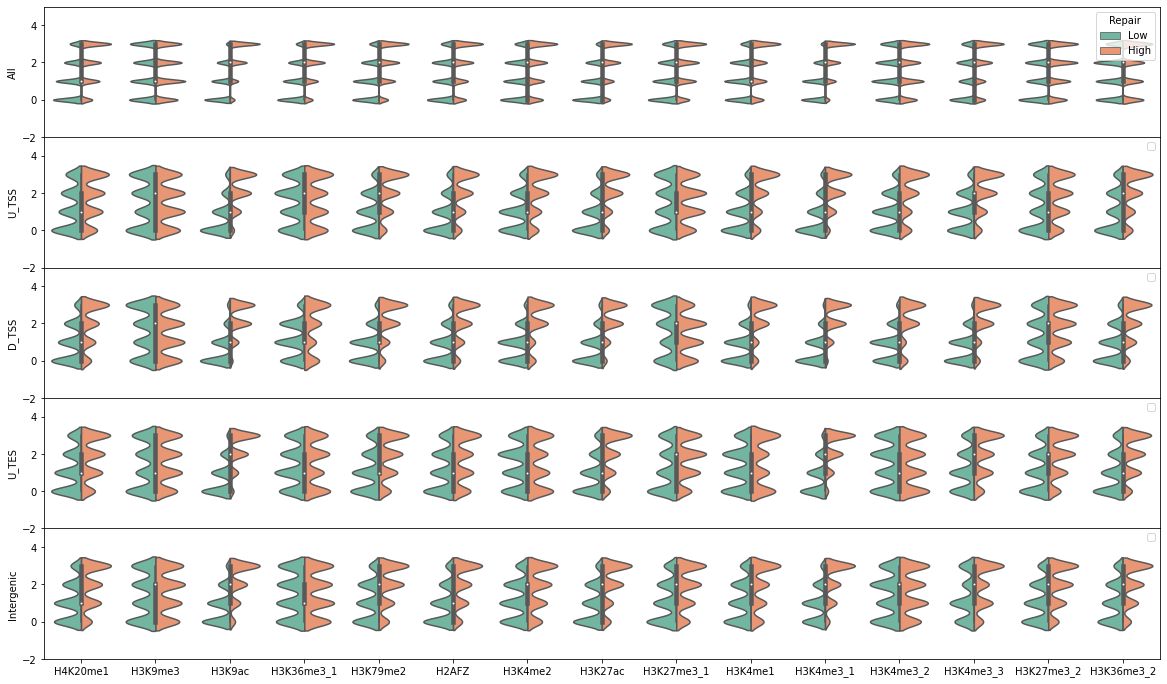

['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']


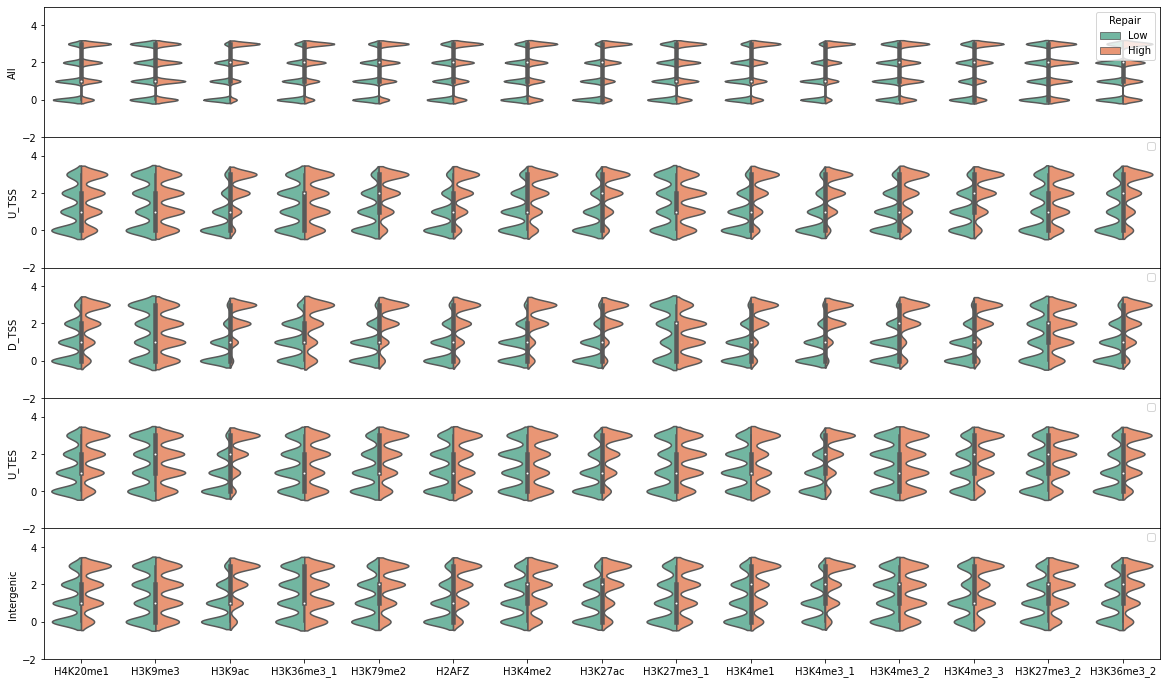

['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']


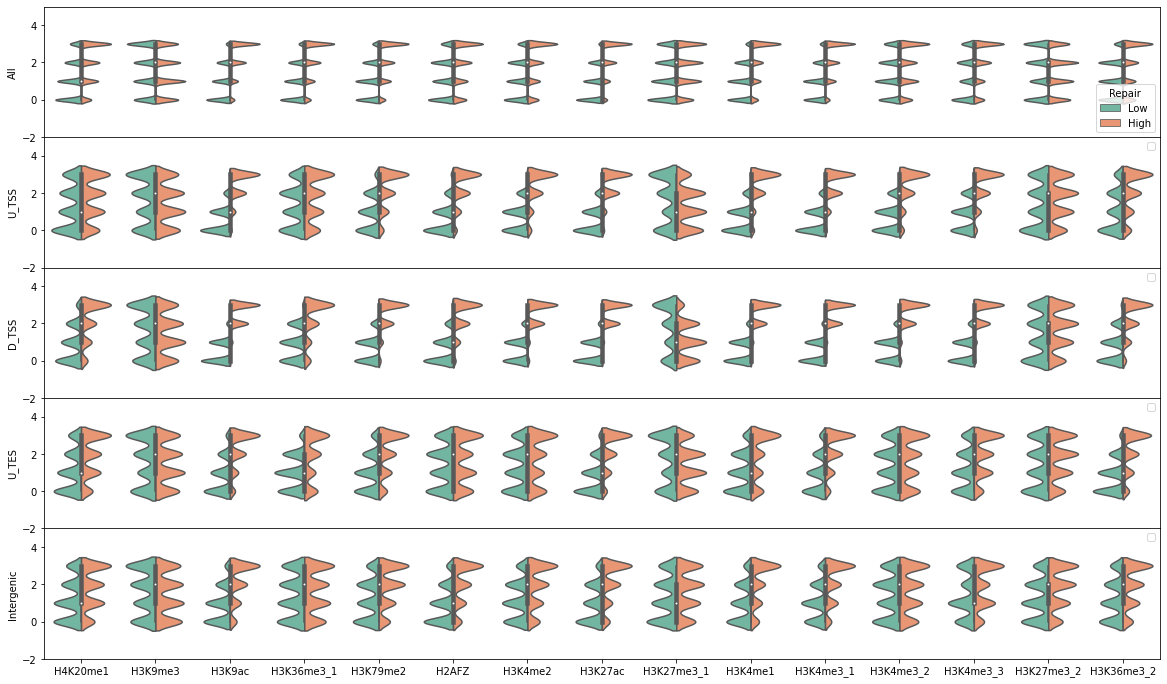

['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']


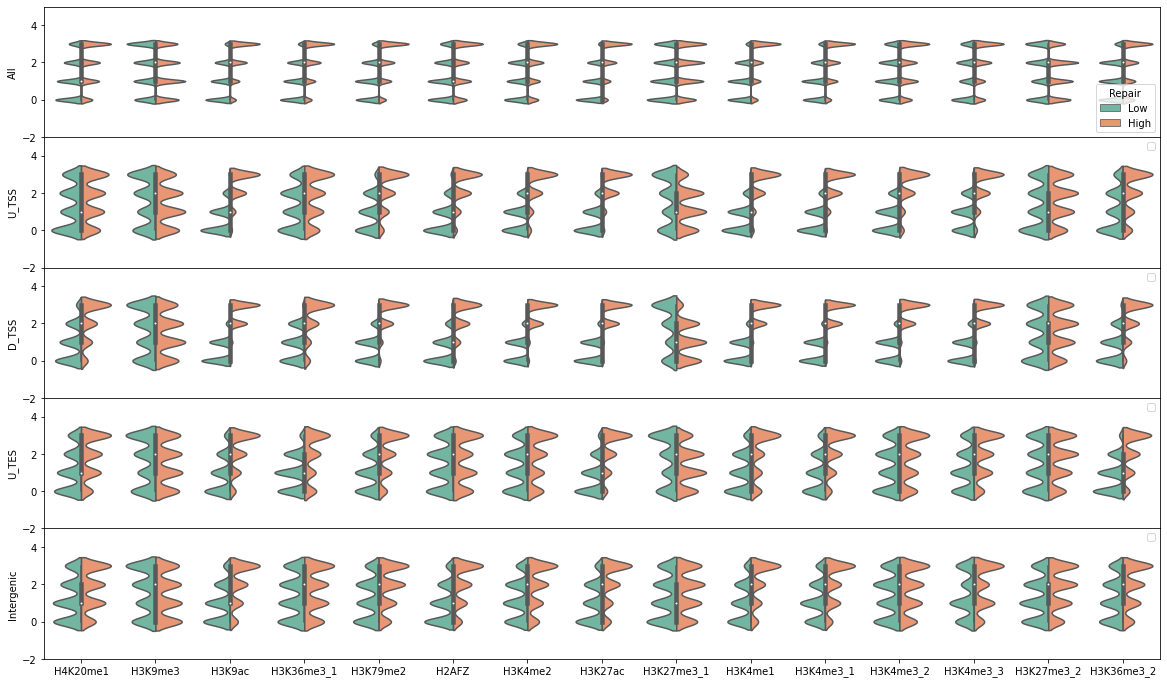

['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K27me3_2', 'H3K36me3_2']


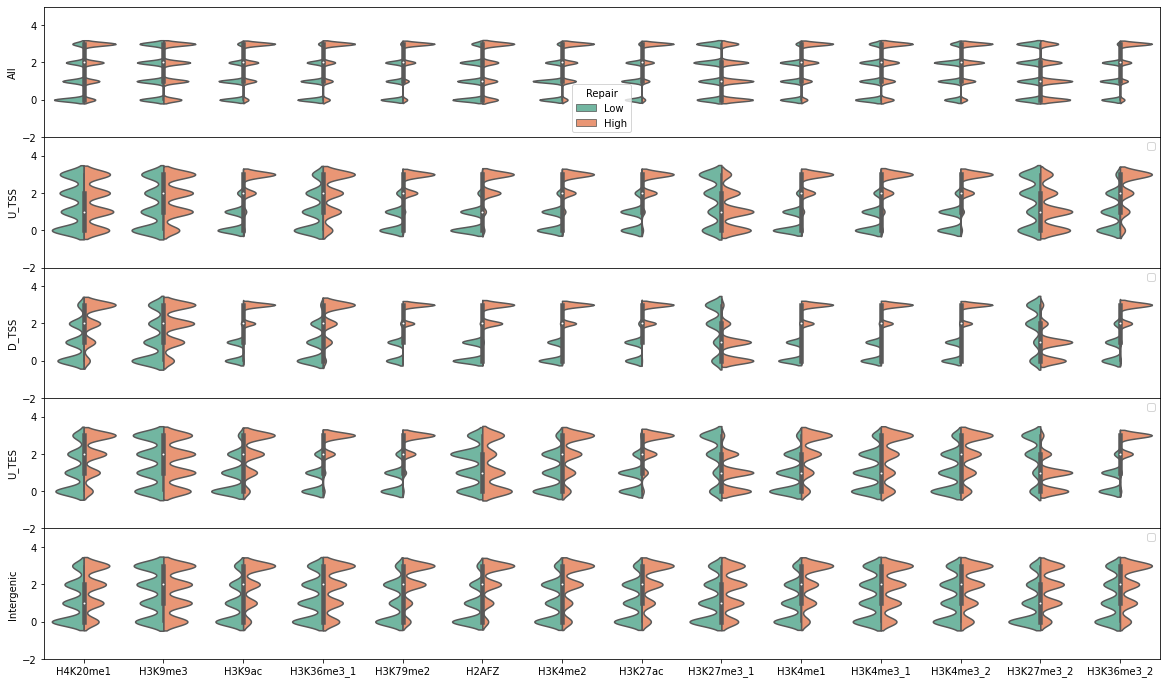

['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K27me3_2', 'H3K36me3_2']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 'H3K4me3_2', 'H3K27me3_2', 'H3K36me3_2']


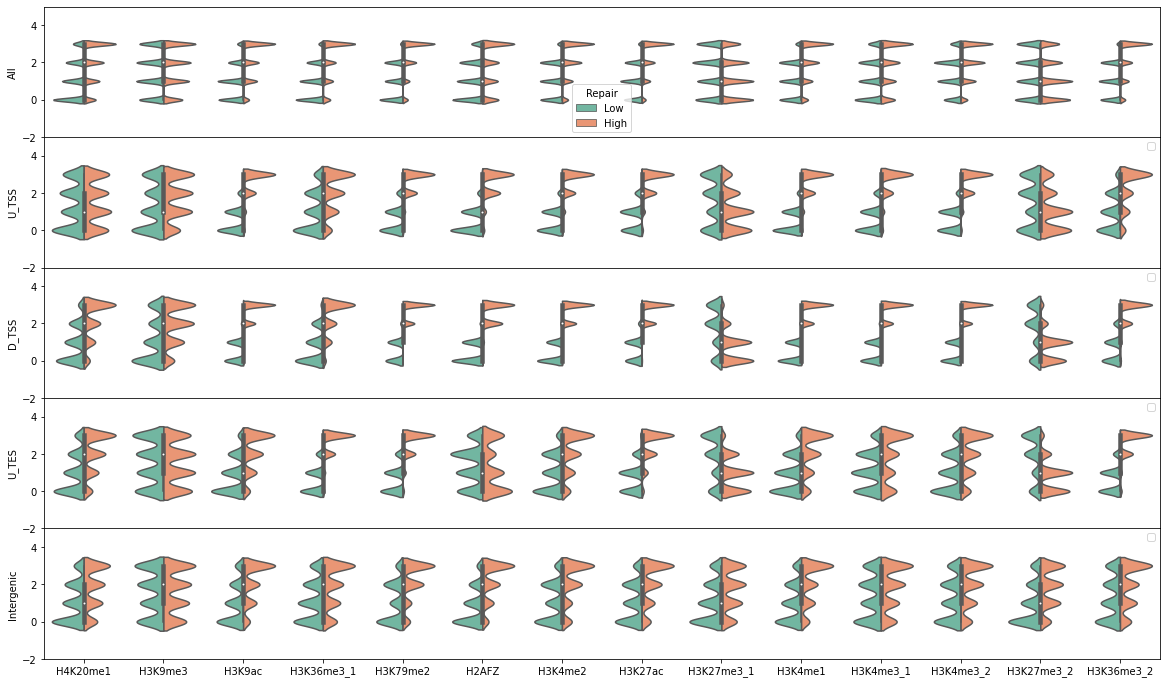

In [ ]:
repairTypes = ['64pp', 'CPD', 'Cisplatin']
regions = regions = ['all','5kBTSS', '5kATSS', '5kBTES', 'intergenic']
regionLabels = ['All','U_TSS', 'D_TSS', 'U_TES', 'Intergenic']
damageSamples = ['DA', 'DB']


for repairType in repairTypes:
  response = '_'.join([repairType, 'A'])
  for damageSample in damageSamples:
    fig, axs = plt.subplots(nrows = len(regions), ncols = 1,
                            figsize=(20, 12),sharex=True,
                            gridspec_kw=dict( hspace=0))
    for i, region in enumerate(regions):
      dat = getRepairRegionDF(repairType, region, damageSample)
      hists = dat.filter(regex='H', axis =1)
      hists = binDF(hists, 4)
      
      repair = pd.DataFrame(dat[response])
      repair = binDF(repair, 3)

      hists['Repair'] = repair

      hists = hists.astype({'Repair': 'int32'})
      hists['Repair'] = hists['Repair'].map({0: -1, 1: np.nan, 2:1})
      hists = hists[hists.Repair.notnull()]

      value_vars = list(hists.columns)[:-1]
      print(value_vars)
      df = pd.melt(hists, id_vars=['Repair'], value_vars=value_vars)
      df['Repair'] = df['Repair'].map({-1.0:'Low', 1.0:'High'})

      sns.violinplot(x = 'variable', y = 'value', hue='Repair',
                     data = df, split= True, hue_order=['Low', 'High'],
                     palette='Set2', ax=axs[i])
      axs[i].set_ylabel(regionLabels[i])
      axs[i].set_xlabel('')
      axs[i].set_ylim((-2,5))      
      if i>0:
        axs[i].legend('')
      
    extensions = ['jpeg', 'pdf']
    for ext in extensions:
      figName = '.'.join(['_'.join([repairType, damageSample, 'discrete_violinplot']), ext])
      plt.savefig(os.path.join(figDir, figName), bbox_inches='tight', dpi=500)
    plt.show()

## Figure 2 new: prediction over all regions. Also, use lone histone modifs?

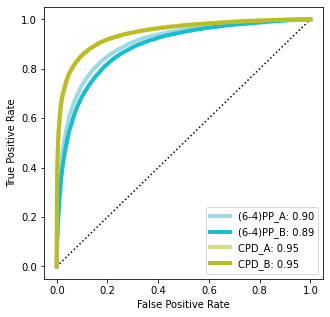

In [31]:
repairTypes = ['64pp', 'CPD']
repairNames = ['(6-4)PP', 'CPD']
regions = ['all']
# regions = ['5kBTSS', '5kATSS', '5kBTES', 'intergenic']
damageSamples =['DA']
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = list(reversed(cmap.colors))  # type: list
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(5,5))
ax.set_prop_cycle(color=colors)
ax.plot([0,1], [0,1], linestyle= ':', c='k')
for i, repairType in enumerate(repairTypes):
  for damageSample in damageSamples:
    for region in regions:
      dat = getRepairRegionDF(repairType, region, damageSample)
      responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
      responsesNames = ['_'.join([repairNames[i], 'A']), '_'.join([repairNames[i], 'B'])]
      for j, response in enumerate(responses):
        paramToUseDict = getBestParamDict(region, response, damageSample)
        myClassifier = XGBClassifier(max_depth=paramToUseDict['max_depth'],
                                     min_child_weight=paramToUseDict['min_child_weight'],
                                     subsample = paramToUseDict['subsample'],
                                     gamma = paramToUseDict["gamma"],
                                     n_estimators = paramToUseDict["n_estimators"])
        chromatin_types = ['All']
        for chromatin_type in chromatin_types:
          xTrain, xTest, yTrain, yTest = getTrainTestData(dat, response, chromatin_type)
          myClassifier.fit(xTrain, yTrain)
          probs = myClassifier.predict_proba(xTest)
          probs = probs[:, 1] # keep probabilities for the positive outcome only
          auc = roc_auc_score(yTest, probs)
          fpr, tpr, thresholds = roc_curve(yTest, probs)          
          ax.plot(fpr,tpr,linewidth=4, 
                  label=str( responsesNames[j] + ': %0.2f') % auc)
        
handles,labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles,labels,loc ="lower right")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

extensions = ['jpeg', 'pdf']
for ext in extensions:
  figName = '.'.join(['_'.join(['Hela','AllChromatin','BestParameters', 
                                'AUC']), ext])
  figDir_name = os.path.join(figDir, figName)
  plt.savefig(figDir_name, bbox_inches='tight', dpi=500,
            bbox_extra_artists=(lgd,))
plt.show() 

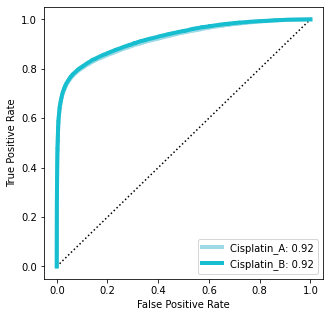

In [30]:
repairTypes = ['Cisplatin']
repairNames = ['Cisplatin']
regions = ['all']
damageSamples =['DA']
name = "tab20"
# cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
# colors = list(reversed(cmap.colors))  # type: list
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(5,5))
ax.set_prop_cycle(color=colors)
ax.plot([0,1], [0,1], linestyle= ':', c='k')
for i, repairType in enumerate(repairTypes):
  for damageSample in damageSamples:
    for region in regions:
      dat = getRepairRegionDF(repairType, region, damageSample)
      responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
      responsesNames = ['_'.join([repairNames[i], 'A']), '_'.join([repairNames[i], 'B'])]
      for j, response in enumerate(responses):
        paramToUseDict = getBestParamDict(region, response, damageSample)
        myClassifier = XGBClassifier(max_depth=paramToUseDict['max_depth'],
                                     min_child_weight=paramToUseDict['min_child_weight'],
                                     subsample = paramToUseDict['subsample'],
                                     gamma = paramToUseDict["gamma"],
                                     n_estimators = paramToUseDict["n_estimators"])
        chromatin_types = ['All']
        for chromatin_type in chromatin_types:
          xTrain, xTest, yTrain, yTest = getTrainTestData(dat, response, chromatin_type)
          myClassifier.fit(xTrain, yTrain)
          probs = myClassifier.predict_proba(xTest)
          probs = probs[:, 1] # keep probabilities for the positive outcome only
          auc = roc_auc_score(yTest, probs)
          fpr, tpr, thresholds = roc_curve(yTest, probs)          
          ax.plot(fpr,tpr,linewidth=4, 
                  label=str( responsesNames[j] + ': %0.2f') % auc)
        
handles,labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles,labels,loc ="lower right")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

extensions = ['jpeg', 'pdf']
for ext in extensions:
  figName = '.'.join(['_'.join(['GM128','AllChromatin','BestParameters', 
                                'AUC']), ext])
  figDir_name = os.path.join(figDir, figName)
  plt.savefig(figDir_name, bbox_inches='tight', dpi=500,
            bbox_extra_artists=(lgd,))
plt.show() 

# Figure 3 new: open and closed chromatin prediction

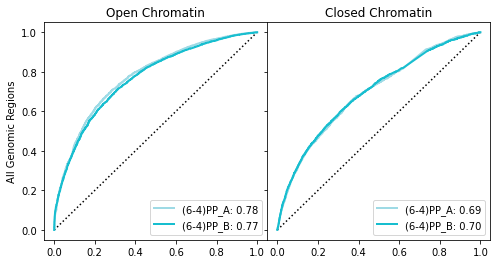

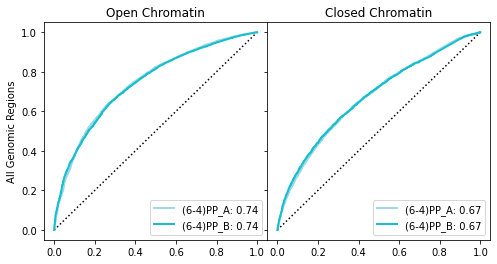

IndexError: ignored

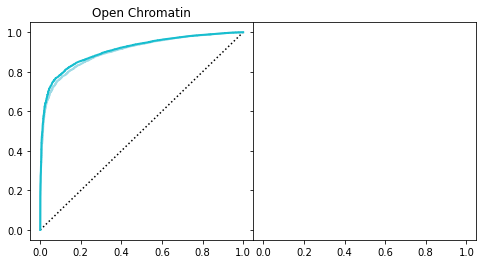

In [33]:
# Stop that pesky warning
pd.options.mode.chained_assignment = None  # default='warn'
os.chdir(dataDir)
repairTypes = ['64pp', 'CPD', 'Cisplatin']
repairNames = ['(6-4)PP', 'CPD', 'Cisplatin']
regions = ['all']
regionLabels = ['All Genomic Regions']
damageSamples = ['DA', 'DB']
chromatin_types = ['open', 'close']

for i, repairType in enumerate(repairTypes):
  responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
  responsesNames = ['_'.join([repairNames[i], 'A']), '_'.join([repairNames[i], 'B'])]
  for damageSample in damageSamples:    
    name = "tab20"
    cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
    colors = list(reversed(cmap.colors))  # type: list
    fig, ax = plt.subplots(nrows=len(regions), ncols=2, figsize=(8,4),
                          sharex = True, sharey='row',
                          gridspec_kw=dict(hspace=0, wspace = 0))                              
    for region in regions:
      dat = getRepairRegionDF(repairType, region, damageSample)
      for j, chromatin_type in enumerate(chromatin_types):
        ax[j].set_prop_cycle(color=colors)
        ax[j].plot([0, 1], [0, 1], linestyle=':', c='k') # plot no skill
        for k, response in enumerate(responses):
          paramToUseDict = getBestParamDict(region, response, damageSample)
          myClassifier = XGBClassifier(max_depth = paramToUseDict["max_depth"],
                                        min_child_weight = paramToUseDict["min_child_weight"],
                                        subsample = paramToUseDict["subsample"],
                                        gamma = paramToUseDict["gamma"],
                                        n_estimators = paramToUseDict["n_estimators"]) 
          xTrain, xTest, yTrain, yTest = getTrainTestData(dat, response, chromatin_type)
          myClassifier.fit(xTrain, yTrain)
          probs = myClassifier.predict_proba(xTest)
          probs = probs[:, 1]
          auc = roc_auc_score(yTest, probs)
          fpr, tpr, thresholds = roc_curve(yTest, probs)   
          ax[j].plot(fpr, tpr,linewidth=2, 
                      label=str( responsesNames[k] + ': %0.2f') % auc)
        if j == 0:
          ax[j].set_title('Open Chromatin')
        if j == 1:
          ax[j].set_title('Closed Chromatin')        
        if j == 0: 
          ax[j].set_ylabel(regionLabels[i])
        handles,labels = ax[j].get_legend_handles_labels()
        lgd = ax[j].legend(handles,labels,loc ="lower right")
    
    extensions = ['jpeg', 'pdf']
    # for ext in extensions:
    #   figName = '.'.join(['_'.join([repairType, damageSample, 
    #                                 'OpenClose','BestParameters', 'AUC']), ext])
    #   figDir_name = os.path.join(figDir, figName)
    #   plt.savefig(figDir_name, bbox_inches='tight', dpi=500,
    #               bbox_extra_artists=(lgd,))
    plt.show()    

# Figure 4 new: AUCs for genomic regions

## new: AUCs for genomic regions

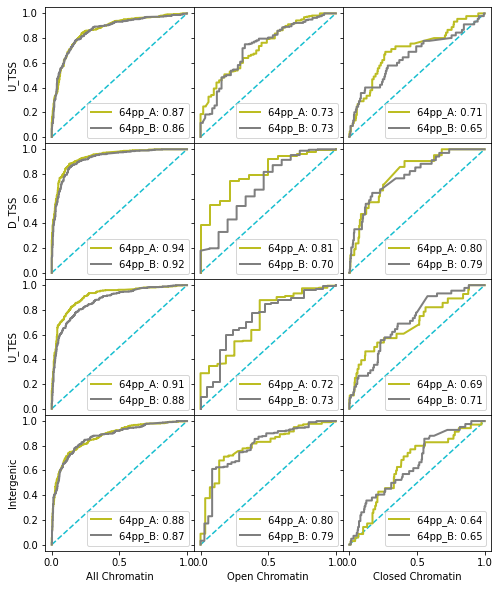

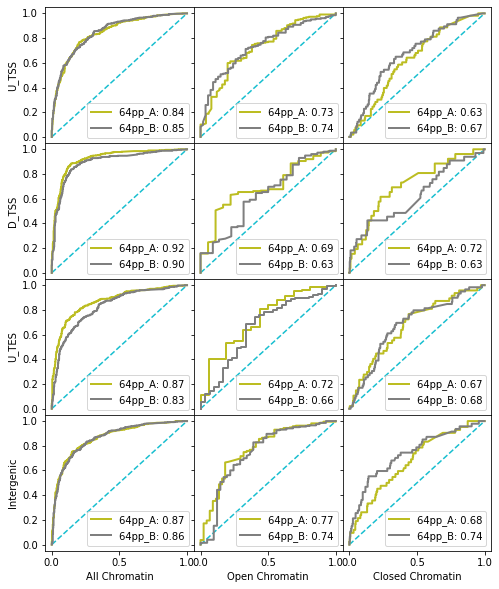

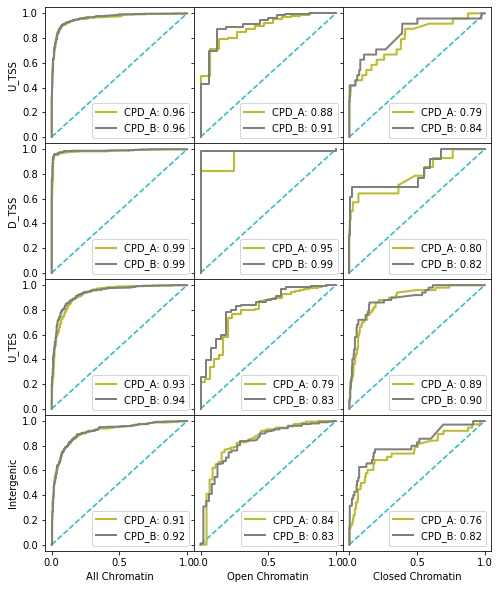

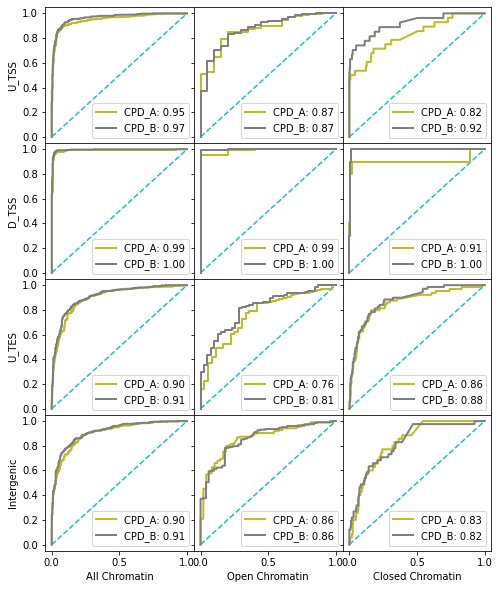

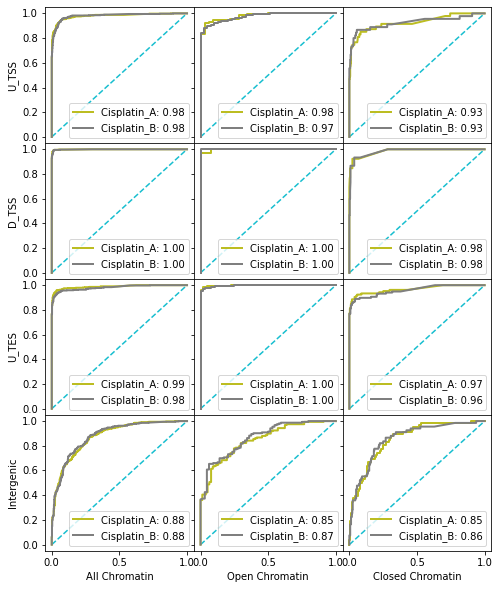

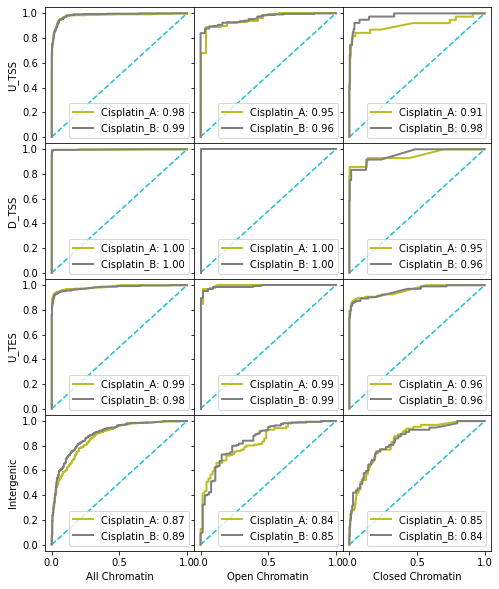

In [ ]:
# Stop that pesky warning
pd.options.mode.chained_assignment = None  # default='warn'
os.chdir(dataDir)
repairTypes = ['64pp', 'CPD', 'Cisplatin']
# repairTypes = ['A64']
regions = ['5kBTSS', '5kATSS', '5kBTES', 'intergenic']
regionLabels = ['U_TSS', 'D_TSS', 'U_TES', 'Intergenic']
damageSamples = ['DA', 'DB']
chromatin_types = ['All', 'open', 'close']

for repairType in repairTypes:
  responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
  for damageSample in damageSamples:    
    name = "tab10"
    cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
    colors = list(reversed(cmap.colors))  # type: list
    fig, ax = plt.subplots(nrows=len(regions), ncols=3, figsize=(8,10),
                          sharex = True, sharey='row',
                          gridspec_kw=dict(hspace=0, wspace = 0))
                          
    for i, region in enumerate(regions):
      dat = getRepairRegionDF(repairType, region, damageSample)
      for j, chromatin_type in enumerate(chromatin_types):  
        ax[i,j].set_prop_cycle(color=colors)
        ax[i,j].plot([0, 1], [0, 1], linestyle='--') # plot no skill              
        for k, response in enumerate(responses):
          paramToUseDict = getBestParamDict(region, response, damageSample)
          myClassifier = XGBClassifier(max_depth = paramToUseDict["max_depth"],
                                        min_child_weight = paramToUseDict["min_child_weight"],
                                        subsample = paramToUseDict["subsample"],
                                        gamma = paramToUseDict["gamma"],
                                        n_estimators = paramToUseDict["n_estimators"])          
          xTrain, xTest, yTrain, yTest = getTrainTestData(dat, response, chromatin_type)
          myClassifier.fit(xTrain, yTrain)
          probs = myClassifier.predict_proba(xTest)            
          probs = probs[:, 1] # keep probabilities for the positive outcome only
          auc = roc_auc_score(yTest, probs)
          fpr, tpr, thresholds = roc_curve(yTest, probs)   
          ax[i,j].plot(fpr, tpr,linewidth=2, 
                      label=str( response + ': %0.2f') % auc)
        if j == 0:
          ax[i,j].set_xlabel('All Chromatin')
        if j == 1:
          ax[i,j].set_xlabel('Open Chromatin')
        if j == 2:
          ax[i,j].set_xlabel('Closed Chromatin')          
        if j == 0: 
          ax[i,j].set_ylabel(regionLabels[i])
        handles,labels = ax[i,j].get_legend_handles_labels()
        lgd = ax[i,j].legend(handles,labels,loc ="lower right")    
    extensions = ['jpeg', 'pdf']
    # extensions = ['jpeg']
    for ext in extensions:
      figName = '.'.join(['_'.join([repairType, damageSample, 
                                    'GenomicRegions','BestParameters', 
                                    'AUC']), ext])
      figDir_name = os.path.join(figDir, figName)
      plt.savefig(figDir_name, bbox_inches='tight', dpi=500,
                  bbox_extra_artists=(lgd,))
    plt.show()    

## old AUCs for open & close

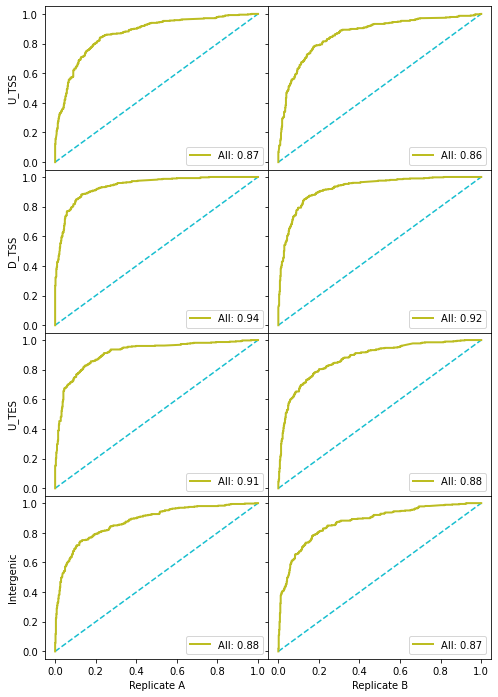

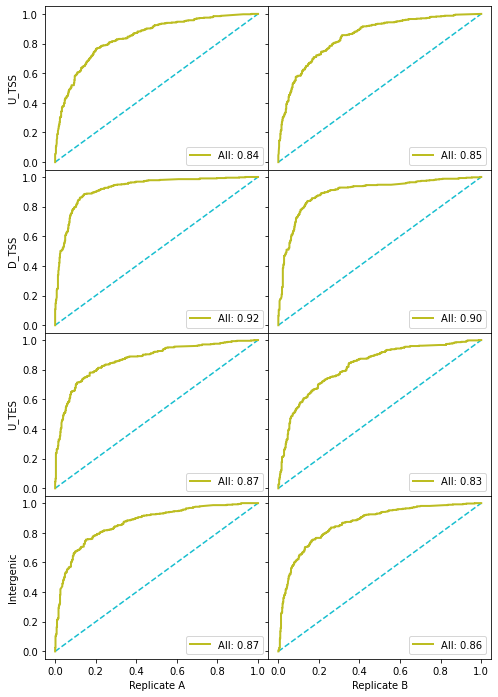

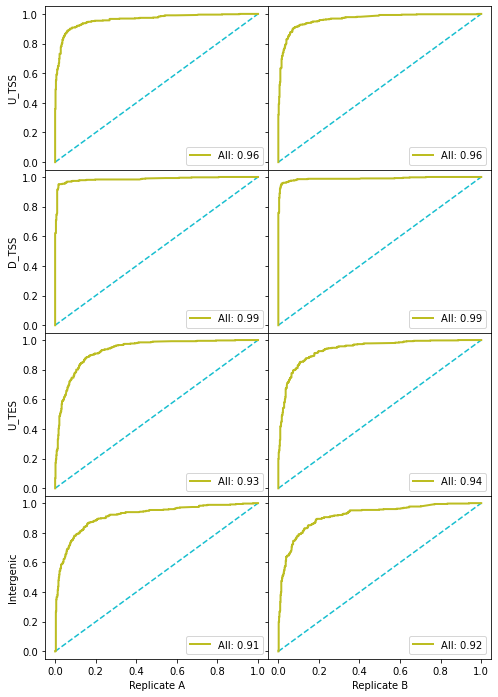

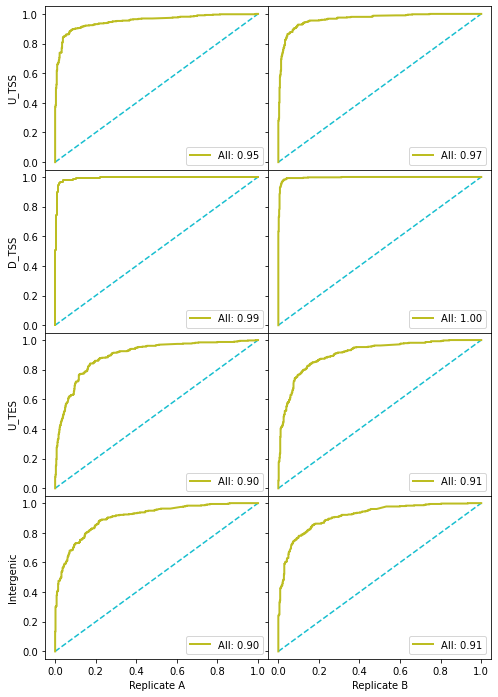

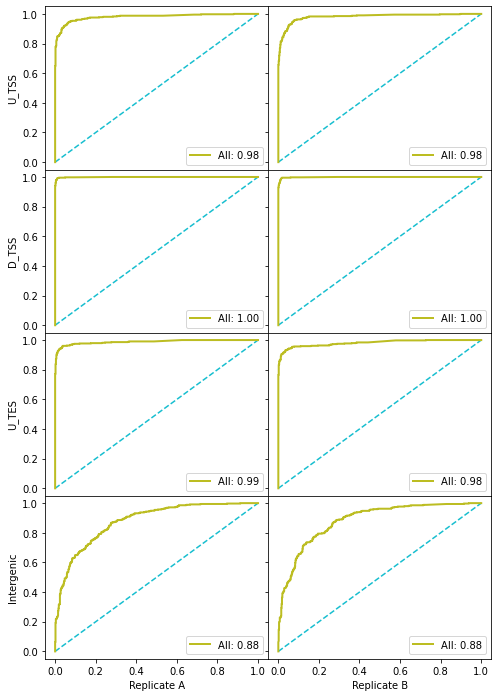

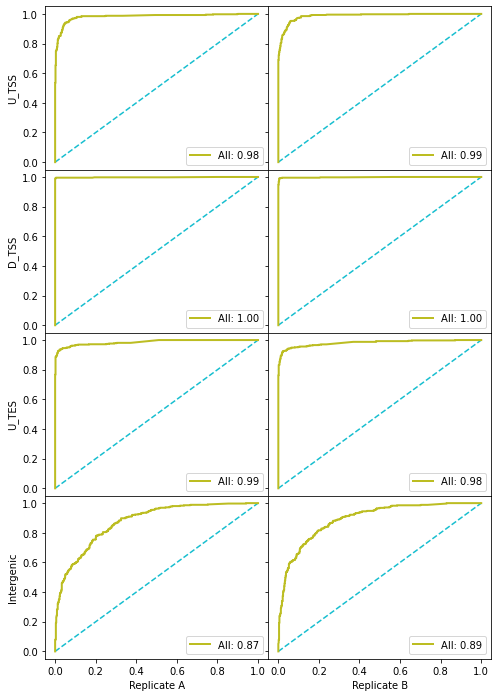

In [ ]:
# Stop that pesky warning
pd.options.mode.chained_assignment = None  # default='warn'
os.chdir(dataDir)
repairTypes = ['64pp', 'CPD', 'Cisplatin']
# repairTypes = ['A64']
regions = ['5kBTSS', '5kATSS', '5kBTES', 'intergenic']
regionLabels = ['U_TSS', 'D_TSS', 'U_TES', 'Intergenic']
damageSamples = ['DA', 'DB']
for repairType in repairTypes:
  # print('Starting', repairType)
  for damageSample in damageSamples:    
    name = "tab10"
    cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
    colors = list(reversed(cmap.colors))  # type: list
    fig, ax = plt.subplots(nrows=len(regions), ncols=2, figsize=(8,12),
                          sharex = True, sharey='row',
                          gridspec_kw=dict(hspace=0, wspace = 0))
                          
    for i, region in enumerate(regions):
      # print('Region:', region)
      dat = getRepairRegionDF(repairType, region, damageSample)
      responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
      for j, response in enumerate(responses):
        paramToUseDict = getBestParamDict(region, response, damageSample)
        myClassifier = XGBClassifier(max_depth = paramToUseDict["max_depth"],
                                      min_child_weight = paramToUseDict["min_child_weight"],
                                      subsample = paramToUseDict["subsample"],
                                      gamma = paramToUseDict["gamma"],
                                      n_estimators = paramToUseDict["n_estimators"])        
        chromatin_types = ['All']
        # chromatin_types = ['open', 'mid', 'close']
        ax[i,j].set_prop_cycle(color=colors)
        ax[i,j].plot([0, 1], [0, 1], linestyle='--') # plot no skill
        for chromatin_type in chromatin_types:
          xTrain, xTest, yTrain, yTest = getTrainTestData(dat, response, chromatin_type)
          myClassifier.fit(xTrain, yTrain)
          probs = myClassifier.predict_proba(xTest)
          # keep probabilities for the positive outcome only
          probs = probs[:, 1]
          auc = roc_auc_score(yTest, probs)
          # print('All AUC: %.3f' % auc)
          fpr, tpr, thresholds = roc_curve(yTest, probs)   
          # plot the roc curve for the model
          ax[i,j].plot(fpr, tpr,linewidth=2, 
                      label=str( chromatin_type + ': %0.2f') % auc)
        # show the plot
        if j == 0:
          ax[i,j].set_xlabel('Replicate A')
        else:
          ax[i,j].set_xlabel('Replicate B')
        
        if j == 0: # Need to change this later to make the region names prettier!!!!!!!
          ax[i,j].set_ylabel(regionLabels[i])

        # ax[i,j].set_ylabel(region)
        # ax[i,j].set_ylabel('True Positive Rate')
        handles,labels = ax[i,j].get_legend_handles_labels()
        # titleName = [region, response, 'Test AUC']
        # titleName = ' '.join(titleName)
        # ax[i,j].set_title(titleName)

        handles,labels = ax[i,j].get_legend_handles_labels()
        lgd = ax[i,j].legend(handles,labels,loc ="lower right")
    
    extensions = ['jpeg', 'pdf']
    # extensions = ['jpeg']
    for ext in extensions:
      figName = '.'.join(['_'.join([repairType, damageSample, 
                                    'AllChromatin','BestParameters', 'AUC']), ext])
      figDir_name = os.path.join(figDir, figName)
      plt.savefig(figDir_name, bbox_inches='tight', dpi=500,
                  bbox_extra_artists=(lgd,))
    plt.show()    

# Stump AUCs

### dataframe

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
loneAUCs = {}
repairTypes = ['64pp', 'CPD', 'Cisplatin']
# repairTypes = ['64pp']
damageSamples = ['DA', 'DB']
regions = ['all','5kBTSS', '5kATSS', '5kBTES', 'intergenic']
chromatin_types = ['All','open', 'close']
for repairType in repairTypes:
  for damageSample in damageSamples:
    for region in regions:
      dat = getRepairRegionDF(repairType, region, damageSample)
      responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
      for response in responses:        
        for chromatin_type in chromatin_types:
          xTrain, xTest, yTrain, yTest = getTrainTestData(dat, response, chromatin_type)
          thisSample = '_'.join([damageSample, region, response, chromatin_type])
          loneAUCs[thisSample] = getAUCForLonePredictors(xTrain, xTest, yTrain, yTest)
df = pd.DataFrame(data = loneAUCs)
df.to_csv('singleFeatures_stumps.csv')

### figure

In [ ]:
# bar plots of top 3 lone predictors for by repair type, damage sample, replicate, open & closed chromatin
# also horizontal lines showing the AUC when all features are used in the model.

In [ ]:
loneAUCs = pd.read_csv('singleFeatures_stumps.csv', index_col=0)
loneAUCs.head()

,DA_all_64pp_A_All,DA_all_64pp_A_open,DA_all_64pp_A_close,DA_all_64pp_B_All,DA_all_64pp_B_open,DA_all_64pp_B_close,DA_5kBTSS_64pp_A_All,DA_5kBTSS_64pp_A_open,DA_5kBTSS_64pp_A_close,DA_5kBTSS_64pp_B_All,DA_5kBTSS_64pp_B_open,DA_5kBTSS_64pp_B_close,DA_5kATSS_64pp_A_All,DA_5kATSS_64pp_A_open,DA_5kATSS_64pp_A_close,DA_5kATSS_64pp_B_All,DA_5kATSS_64pp_B_open,DA_5kATSS_64pp_B_close,DA_5kBTES_64pp_A_All,DA_5kBTES_64pp_A_open,DA_5kBTES_64pp_A_close,DA_5kBTES_64pp_B_All,DA_5kBTES_64pp_B_open,DA_5kBTES_64pp_B_close,DA_intergenic_64pp_A_All,DA_intergenic_64pp_A_open,DA_intergenic_64pp_A_close,DA_intergenic_64pp_B_All,DA_intergenic_64pp_B_open,DA_intergenic_64pp_B_close,DB_all_64pp_A_All,DB_all_64pp_A_open,DB_all_64pp_A_close,DB_all_64pp_B_All,DB_all_64pp_B_open,DB_all_64pp_B_close,DB_5kBTSS_64pp_A_All,DB_5kBTSS_64pp_A_open,DB_5kBTSS_64pp_A_close,DB_5kBTSS_64pp_B_All,...,DA_5kBTES_Cisplatin_A_close,DA_5kBTES_Cisplatin_B_All,DA_5kBTES_Cisplatin_B_open,DA_5kBTES_Cisplatin_B_close,DA_intergenic_Cisplatin_A_All,DA_intergenic_Cisplatin_A_open,DA_intergenic_Cisplatin_A_close,DA_intergenic_Cisplatin_B_All,DA_intergenic_Cisplatin_B_open,DA_intergenic_Cisplatin_B_close,DB_all_Cisplatin_A_All,DB_all_Cisplatin_A_open,DB_all_Cisplatin_A_close,DB_all_Cisplatin_B_All,DB_all_Cisplatin_B_open,DB_all_Cisplatin_B_close,DB_5kBTSS_Cisplatin_A_All,DB_5kBTSS_Cisplatin_A_open,DB_5kBTSS_Cisplatin_A_close,DB_5kBTSS_Cisplatin_B_All,DB_5kBTSS_Cisplatin_B_open,DB_5kBTSS_Cisplatin_B_close,DB_5kATSS_Cisplatin_A_All,DB_5kATSS_Cisplatin_A_open,DB_5kATSS_Cisplatin_A_close,DB_5kATSS_Cisplatin_B_All,DB_5kATSS_Cisplatin_B_open,DB_5kATSS_Cisplatin_B_close,DB_5kBTES_Cisplatin_A_All,DB_5kBTES_Cisplatin_A_open,DB_5kBTES_Cisplatin_A_close,DB_5kBTES_Cisplatin_B_All,DB_5kBTES_Cisplatin_B_open,DB_5kBTES_Cisplatin_B_close,DB_intergenic_Cisplatin_A_All,DB_intergenic_Cisplatin_A_open,DB_intergenic_Cisplatin_A_close,DB_intergenic_Cisplatin_B_All,DB_intergenic_Cisplatin_B_open,DB_intergenic_Cisplatin_B_close
H4K20me1,0.652840,0.506286,0.537381,0.646878,0.510127,0.539280,0.581363,0.524359,0.579994,0.574685,0.552508,0.560101,0.682456,0.635769,0.508225,0.676474,0.691829,0.509693,0.636271,0.577083,0.509615,0.608205,0.535714,0.496123,0.645458,0.471163,0.526081,0.651400,0.518211,0.489796,0.637144,0.503477,0.534512,0.627039,0.507398,0.537851,0.568976,0.524658,0.490226,0.568681,...,0.665894,0.652939,0.503125,0.644060,0.616235,0.542948,0.616027,0.629534,0.534058,0.577192,0.680773,0.630308,0.586052,0.688496,0.639681,0.590480,0.543662,0.473836,0.492850,0.543091,0.472302,0.533378,0.682392,0.566346,0.527757,0.686071,0.509690,0.533772,0.672618,0.514222,0.656025,0.666161,0.495602,0.648507,0.602575,0.569970,0.531764,0.632187,0.588051,0.532693
H3K9me3,0.506273,0.452429,0.428469,0.507637,0.460179,0.449957,0.543896,0.577784,0.462081,0.551177,0.589734,0.522917,0.526306,0.576881,0.603030,0.526145,0.416861,0.603148,0.562491,0.500000,0.395604,0.546935,0.513393,0.410753,0.562677,0.490235,0.486983,0.555208,0.485779,0.522109,0.511982,0.465886,0.466464,0.510751,0.476821,0.478306,0.536325,0.563790,0.413876,0.538986,...,0.507079,0.505129,0.528125,0.506671,0.503237,0.518289,0.471481,0.492832,0.514042,0.430457,0.490027,0.445074,0.522398,0.486492,0.435901,0.521207,0.617702,0.585259,0.580753,0.619320,0.560161,0.601680,0.654147,0.625962,0.520462,0.648522,0.606589,0.524561,0.496026,0.564692,0.490053,0.500707,0.566319,0.483340,0.509452,0.509835,0.471536,0.506915,0.520221,0.466096
H3K9ac,0.784143,0.550944,0.552939,0.767024,0.544084,0.549942,0.778166,0.543405,0.540320,0.778741,0.529467,0.548201,0.851635,0.486641,0.563636,0.844283,0.523606,0.581193,0.811391,0.529167,0.576923,0.769362,0.533482,0.556631,0.773211,0.553479,0.540179,0.754064,0.567696,0.523810,0.723941,0.637560,0.504019,0.705559,0.622513,0.503760,0.762842,0.536301,0.521219,0.768486,...,0.678250,0.707597,0.690625,0.660159,0.657931,0.647789,0.572815,0.708030,0.681373,0.656856,0.720182,0.749871,0.585532,0.724096,0.752690,0.590051,0.910714,0.700809,0.810740,0.907363,0

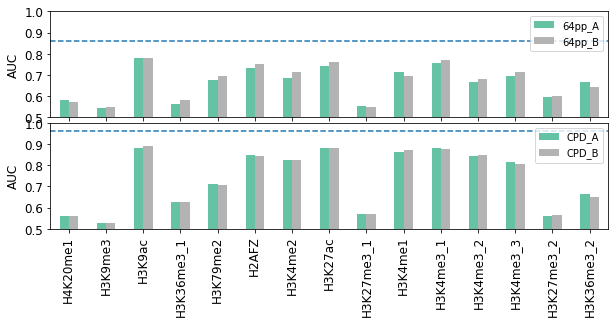

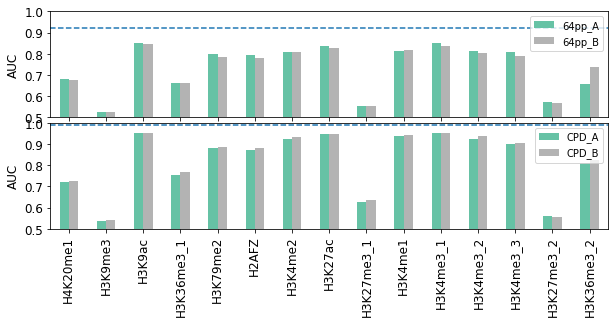

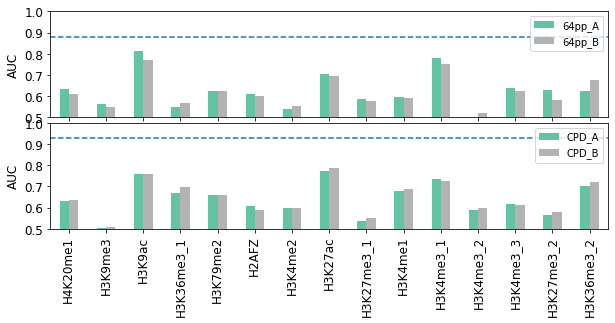

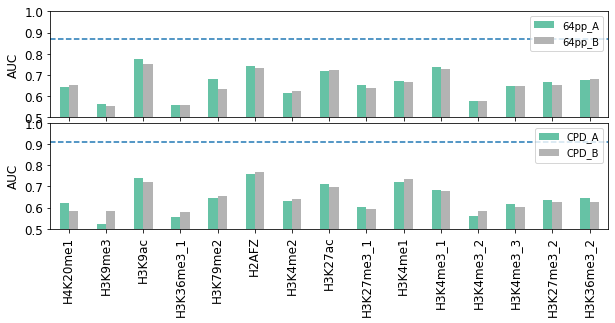

In [ ]:
# repairTypes = ['64pp', 'CPD', 'Cisplatin']
repairTypes = ['64pp', 'CPD']
# allAUC= [0.86, 0.96]
# damageSamples = ['DA', 'DB']
damageSamples = ['DA']
# regions = ['all']
regions = ['5kBTSS', '5kATSS', '5kBTES', 'intergenic']
chromatin_type = 'All'

name = "tab10"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = list(reversed(cmap.colors))  # type: list

for region in regions:
  if region == '5kBTSS':
    allAUC= [0.86, 0.96]
  if region == '5kATSS':
    allAUC= [0.92, 0.99]
  if region == '5kBTES':
    allAUC= [0.88, 0.93]
  if region == 'intergenic':
    allAUC= [0.87, 0.91]
  if region == 'all':
    allAUC= [0.89, 0.95]
  
  fig, ax = plt.subplots(nrows=len(repairTypes), ncols=1, figsize=(10,4),
                            sharex = True, sharey='row',
                            gridspec_kw=dict(hspace=0.05, wspace = 0))
  for i, repairType in enumerate(repairTypes):
    for damageSample in damageSamples:
      responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
      cols = ['_'.join([damageSample, region, responses[0], chromatin_type]),
              '_'.join([damageSample, region, responses[1], chromatin_type])]

      thisRepairAUCs = loneAUCs[cols]
      
      ax[i].set_ylabel("AUC", fontsize=12)
      thisRepairAUCs.plot(kind='bar', fontsize=12, cmap='Set2', ax= ax[i])
      ax[i].legend(([responses[0], responses[1]]), loc=1)
      
      ax[i].set_ylim(0.5, 1)
      ax[i].axhline(allAUC[i], linestyle = '--')
  extensions = ['jpeg', 'pdf']
  # extensions = ['jpeg']
  for ext in extensions:
    figName = '.'.join(['_'.join(['Hela','LoneHistones', 
                                  'Chromatin', chromatin_type, 
                                  'region',region, 
                                  'Stump', 'AUC']), ext])
    figDir_name = os.path.join(figDir, figName)
    plt.savefig(figDir_name, bbox_inches='tight', dpi=500)
  plt.show()    

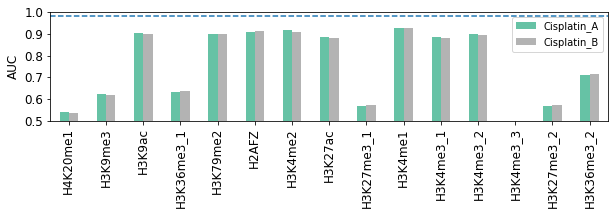

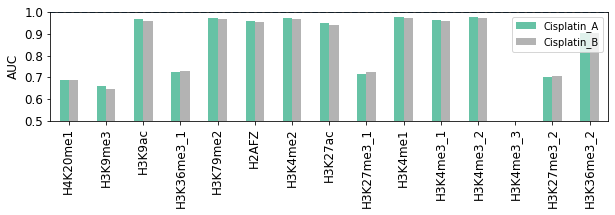

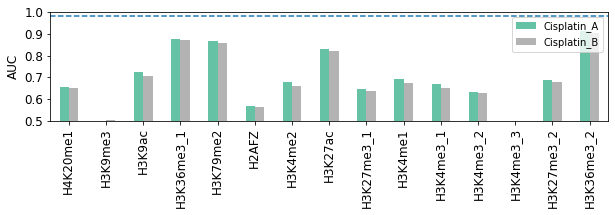

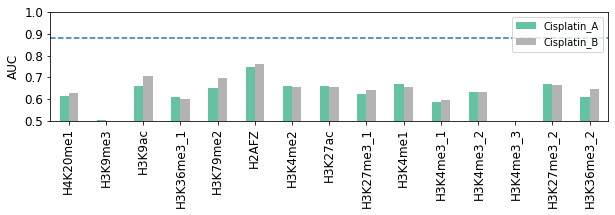

In [ ]:
# repairTypes = ['64pp', 'CPD', 'Cisplatin']
repairTypes = ['Cisplatin']
allAUC= [0.87]
# damageSamples = ['DA', 'DB']
damageSamples = ['DA']
# regions = ['all']
regions = ['5kBTSS', '5kATSS', '5kBTES', 'intergenic']
chromatin_type = 'All'

name = "tab10"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = list(reversed(cmap.colors))  # type: list

for region in regions:
  if region == '5kBTSS':
    allAUC= [0.98]
  if region == '5kATSS':
    allAUC= [1]
  if region == '5kBTES':
    allAUC= [0.98]
  if region == 'intergenic':
    allAUC= [0.88]
  if region == 'all':
    allAUC= [0.92]
  for i, repairType in enumerate(repairTypes):
    for damageSample in damageSamples:
      responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
      cols = ['_'.join([damageSample, region, responses[0], chromatin_type]),
              '_'.join([damageSample, region, responses[1], chromatin_type])]

      thisRepairAUCs = loneAUCs[cols]
      
      
      ax = thisRepairAUCs.plot(kind='bar', figsize=(10, 2),fontsize=12, cmap='Set2')
      ax.set_ylabel("AUC", fontsize=12)
      ax.legend(([responses[0], responses[1]]), loc=1)
      
      ax.set_ylim(0.5, 1)
      ax.axhline(allAUC[i], linestyle = '--')
  extensions = ['jpeg', 'pdf']
  # extensions = ['jpeg']
  for ext in extensions:
    figName = '.'.join(['_'.join(['GM128','LoneHistones', 
                                  'Chromatin', chromatin_type, 
                                  'region',region,
                                  'Stump', 'AUC']), ext])
    figDir_name = os.path.join(figDir, figName)
    plt.savefig(figDir_name, bbox_inches='tight', dpi=500)
  plt.show()    

In [ ]:
thisRepairAUCs = loneAUCs.filter(regex=thisRepair)
thisRepairAUCs.head()

,64pp_DA_all_64pp_A_open,64pp_DA_all_64pp_A_close,64pp_DA_all_64pp_B_open,64pp_DA_all_64pp_B_close,64pp_DA_5kBTSS_64pp_A_open,64pp_DA_5kBTSS_64pp_A_close,64pp_DA_5kBTSS_64pp_B_open,64pp_DA_5kBTSS_64pp_B_close,64pp_DA_5kATSS_64pp_A_open,64pp_DA_5kATSS_64pp_A_close,64pp_DA_5kATSS_64pp_B_open,64pp_DA_5kATSS_64pp_B_close,64pp_DA_5kBTES_64pp_A_open,64pp_DA_5kBTES_64pp_A_close,64pp_DA_5kBTES_64pp_B_open,64pp_DA_5kBTES_64pp_B_close,64pp_DA_intergenic_64pp_A_open,64pp_DA_intergenic_64pp_A_close,64pp_DA_intergenic_64pp_B_open,64pp_DA_intergenic_64pp_B_close
H4K20,0.506286,0.537381,0.510127,0.539280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H3K9me3,0.452429,0.428469,0.460179,0.449957,0.577784,0.462081,0.589734,0.522917,0.576881,0.603030,0.416861,0.603148,0.500000,0.395604,0.513393,0.410753,0.490235,0.486983,0.485779,0.522109
H3K9ac,0.550944,0.552939,0.544084,0.549942,0.543405,0.540320,0.529467,0.548201,0.486641,0.563636,0.523606,0.581193,0.529167,0.576923,0.533482,0.556631,0.553479,0.540179,0.567696,0.523810
H3K36me3,0.547570,0.556633,0.553098,0.569486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H3K79me2,0.557824,0.554867,0.598635,0.552352,0.550143,0.565620,0.586050,0.566982,0.527535,0.573593,0.592477,0.508119,0.462500,0.491758,0.523065,0.518345,0.573314,0.506344,0.583076,0.508503


In [ ]:
thisRegion = thisRepairAUCs.filter(regex='all')


,64pp_DA_all_64pp_A_open,64pp_DA_all_64pp_A_close,64pp_DA_all_64pp_B_open,64pp_DA_all_64pp_B_close
H4K20,0.506286,0.537381,0.510127,0.539280
H3K9me3,0.452429,0.428469,0.460179,0.449957
H3K9ac,0.550944,0.552939,0.544084,0.549942
H3K36me3,0.547570,0.556633,0.553098,0.569486
H3K79me2,0.557824,0.554867,0.598635,0.552352


In [ ]:
responses =  ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
response = '64pp_A'
thisResponse = thisRegion.filter(regex=response)
thisResponse.head()

,64pp_DA_all_64pp_A_open,64pp_DA_all_64pp_A_close
H4K20,0.506286,0.537381
H3K9me3,0.452429,0.428469
H3K9ac,0.550944,0.552939
H3K36me3,0.547570,0.556633
H3K79me2,0.557824,0.554867


In [ ]:
region = 'open'
thisChromatin = thisResponse.filter(regex=region)
thisChromatin

,64pp_DA_all_64pp_A_open
H4K20,0.506286
H3K9me3,0.452429
H3K9ac,0.550944
H3K36me3,0.547570
H3K79me2,0.557824
H2AFZ,0.535788
H3K4me2,0.543435
H3K27ac,0.646471
H3K27me3,0.470370
H3K4me1,0.598282


In [ ]:
thisNameOpen = '_'.join([repairType, damageSample, region, response, 'open'])
thisNameClose = '_'.join([repairType, damageSample, region, response, 'close'])

thisOpen = loneAUCs.filter(regex=thisNameOpen)
thisClose = loneAUCs.filter(regex=thisNameClose)


In [ ]:
thisTop3 = thisChromatin.sort_values(by = thisChromatin.columns[0], ascending=False)[:3]

In [ ]:
list(thisTop3.iloc[:,0])

[0.646470988498099, 0.5982816458976714, 0.5662344413345195]

<BarContainer object of 3 artists>

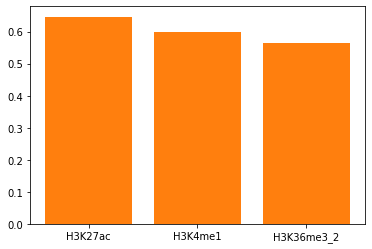

In [ ]:
plt.bar(x = list(thisTop3.index), height = list(thisTop3.iloc[:,0]))
plt.bar(x = list(thisTop3.index), height = list(thisTop3.iloc[:,0]))

# Figure 3: Shap

## dataframe

In [ ]:
repairTypes = ['64pp', 'CPD', 'Cisplatin']
# repairTypes = ['CPD']
regions = ['all', '5kBTSS', '5kATSS', '5kBTES', 'intergenic']
# regions = ['5kBTSS']
damageSamples = ['DA', 'DB']
chromatin_types = ['All', 'open', 'close']

In [ ]:
# Stop that pesky warning
pd.options.mode.chained_assignment = None  # default='warn'

for repairType in repairTypes:
  for damageSample in damageSamples:
    if repairType == 'Cisplatin':
      histones = ['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1',
                  'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 
                  'H3K4me1','H3K4me3_1', 'H3K4me3_2', 'H3K27me3_2', 'H3K36me3_2']
    else:
      histones = ['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ',
              'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 
              'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']              

    thisRepairOneZeroDF = pd.DataFrame(columns=histones)
    thisRepairShapValDF = pd.DataFrame(columns=histones)
    
    for i, region in enumerate(regions):
      dat = getRepairRegionDF(repairType, region, damageSample)
      responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]

      for j, response in enumerate(responses):
        paramToUseDict = getBestParamDict(region, response, damageSample)
        myClassifier = XGBClassifier(max_depth = paramToUseDict["max_depth"],
                                      min_child_weight = paramToUseDict["min_child_weight"],
                                      subsample = paramToUseDict["subsample"],
                                      gamma = paramToUseDict["gamma"],
                                      n_estimators = paramToUseDict["n_estimators"])       
        
        thisRespRegShapPos = [0] * len(histones) #hold top shap positions
        thisRespRegShapVal = [0] * len(histones) #hold top shap values        
        
        for chromatin_type in chromatin_types:
          thisRespRegIndexName = '_'.join([response, region, damageSample, chromatin_type])

          xTrain, xTest, yTrain, yTest = getTrainTestData(dat, response, chromatin_type)
          histones = list(xTest.columns)
          myClassifier.fit(xTrain, yTrain)

          explainer = shap.TreeExplainer(myClassifier)
          shap_values = explainer.shap_values(xTest)       
          shapValues = pd.DataFrame(shap_values)
          shapValues.columns = xTest.columns
          global_shap_values = np.abs(shapValues).mean(0)
          
          global_shap_values2 = global_shap_values.sort_values(ascending=False) 
          global_shap_values2 = pd.DataFrame(global_shap_values2).reset_index()
          global_shap_values2.columns = ['histone', 'meanAbsSHAP']        
          
          for i, hist in enumerate(histones):
            thisHistIndex = global_shap_values2.index[global_shap_values2['histone'] == hist].tolist()[0]
            thisHistShapVal = global_shap_values2[global_shap_values2['histone']== hist]['meanAbsSHAP'].tolist()[0]
            # if thisHistIndex in [0,1,2,3,4]:
            if thisHistIndex in [0,1,2]:
              thisRespRegShapPos[i] = 1
              thisRespRegShapVal[i] = thisHistShapVal

          thisRespRegShapPos = pd.Series(thisRespRegShapPos, 
                                        name = thisRespRegIndexName, 
                                        index=histones) 
          thisRespRegShapVal = pd.Series(thisRespRegShapVal, 
                                        name = thisRespRegIndexName, 
                                        index=histones)
          thisRepairOneZeroDF = thisRepairOneZeroDF.append(thisRespRegShapPos)
          thisRepairShapValDF = thisRepairShapValDF.append(thisRespRegShapVal)
   
  fnameOneZero = '.'.join(['_'.join([repairType, damageSample, 'OneZero']), 'pickle'])
  fnameShapVal = '.'.join(['_'.join([repairType, damageSample, 'ShapVal']), 'pickle'])
  with open(fnameOneZero, 'wb') as handle:
      pickle.dump(thisRepairOneZeroDF, handle)
  with open(fnameShapVal, 'wb') as handle:
      pickle.dump(thisRepairShapValDF, handle)

# with open('globalShapValues.pickle', 'rb') as handle:
#     shapVals = pickle.load(handle)

## figure

In [ ]:
for repairType in repairTypes:
  for damageSample in damageSamples:
    fnameShapVal = '.'.join(['_'.join([repairType, damageSample, 'ShapVal']), 'pickle'])
    with open(fnameShapVal, 'rb') as handle:
        shapVal = pickle.load(handle)

    shapVal_annot = shapVal.applymap(lambda x:'' if x==0 else str(x)[:4])
    yTicks = ['all_RepA', 'all_RepB',
              'U_TSS_RepA','U_TSS_RepB',
              'D_TSS_RepA', 'D_TSS_RepB',
              'U_TES_RepA','U_TES_RepB',
              'Intergenic_RepA', 'Intergenic_RepB']

    chromatin_types = ['All','open','close']
    # chromatin_types = ['all']

    fig = plt.figure(figsize = (10,2)) # width x height
    ax1 = fig.add_subplot(1, 3, 1) # row, column, position
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)

    for chromatin_type  in chromatin_types:
      inds = [ind for ind in list(shapVal.index) if chromatin_type in ind]
      chromatin = shapVal.reindex(inds)
      annot = shapVal_annot.reindex(inds)

      if chromatin_type == 'All':
        sns.heatmap(chromatin, ax = ax1, linewidths=.5,cmap = "pink", cbar=False,
                    yticklabels=yTicks,fmt = '')
        ax1.set_title(chromatin_type)
        figName = '.'.join(['_'.join([repairType, damageSample, chromatin_type, 'shapImp']), 'jpeg'])

      if chromatin_type == 'open':
        sns.heatmap(chromatin, ax = ax2, linewidths=.5,cmap = "pink", cbar=False,  
                    yticklabels=False, fmt = '')
        ax2.set_title(chromatin_type)
        figName = '.'.join(['_'.join([repairType, chromatin_type, 'shapImp']), 'jpeg'])
        

      if chromatin_type == 'close':
        sns.heatmap(chromatin, ax = ax3, linewidths=.5,cmap = "pink", cbar=False,  
                    yticklabels=False,fmt = '')
        ax3.set_title(chromatin_type)
        
        extensions = ['jpeg', 'pdf']
        for ext in extensions:
          figName = '.'.join(['_'.join([repairType, damageSample, 'shapImp']), ext])
          figDir_name = os.path.join(figDir, figName)
          plt.savefig(figDir_name, bbox_inches='tight', dpi=500)
        plt.show()


#figure 5 new, shap plots

In [ ]:
# Stop that pesky warning
pd.options.mode.chained_assignment = None  # default='warn'
repairTypes = ['64pp', 'CPD', 'Cisplatin']
damageSample = 'DA'
regions = ['all', '5kBTSS', '5kATSS', '5kBTES', 'intergenic']
for repairType in repairTypes:  
  for i, region in enumerate(regions):
    dat = getRepairRegionDF(repairType, region, damageSample)
    responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]

    for j, response in enumerate(responses):

      paramToUseDict = getBestParamDict(region, response, damageSample)
      myClassifier = XGBClassifier(max_depth = paramToUseDict["max_depth"],
                                    min_child_weight = paramToUseDict["min_child_weight"],
                                    subsample = paramToUseDict["subsample"],
                                    gamma = paramToUseDict["gamma"],
                                    n_estimators = paramToUseDict["n_estimators"]) 
      
      chromatin_types = ['All', 'open', 'close']
      
      for chromatin_type in chromatin_types:
        xTrain, xTest, yTrain, yTest = getTrainTestData(dat, response, chromatin_type)
        myClassifier.fit(xTrain, yTrain)

        explainer = shap.TreeExplainer(myClassifier)
        shap_values = explainer.shap_values(xTest)
        fig = shap.summary_plot(shap_values, xTest, show= False, color = 'tab10')
        figName = '_'.join([response, region, chromatin_type, 'shap'])
        figName = '.'.join([figName, 'jpeg'])
        figDir_name = os.path.join(figDir, figName)
        plt.savefig(figDir_name, bbox_inches='tight', dpi=500)
        plt.show()
        

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!ls 

64pp_5kATSS_DA_normalized.csv	    Cisplatin_DA_ShapVal.pickle
64pp_5kATSS_DB_normalized.csv	    Cisplatin_DB_OneZero.pickle
64pp_5kBTES_DA_normalized.csv	    Cisplatin_DB_shapImp.jpeg
64pp_5kBTES_DB_normalized.csv	    Cisplatin_DB_ShapVal.pickle
64pp_5kBTSS_DA_normalized.csv	    Cisplatin_intergenic_DA_normalized.csv
64pp_5kBTSS_DB_normalized.csv	    Cisplatin_intergenic_DB_normalized.csv
64pp_all_DA_normalized.csv	    CPD_5kATSS_DA_normalized.csv
64pp_all_DB_normalized.csv	    CPD_5kATSS_DB_normalized.csv
64pp_DA_OneZero.pickle		    CPD_5kBTES_DA_normalized.csv
64pp_DA_shapImp.jpeg		    CPD_5kBTES_DB_normalized.csv
64pp_DA_ShapVal.pickle		    CPD_5kBTSS_DA_normalized.csv
64pp_DB_OneZero.pickle		    CPD_5kBTSS_DB_normalized.csv
64pp_DB_shapImp.jpeg		    CPD_all_DA_normalized.csv
64pp_DB_ShapVal.pickle		    CPD_all_DB_normalized.csv
64pp_intergenic_DA_normalized.csv   CPD_DA_OneZero.pickle
64pp_intergenic_DB_normalized.csv   CPD_DA_shapImp.jpeg
Cisplatin_5kATSS_DA_normalized.csv  CPD_DA